In [8]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm

In [9]:
# Paths

data_path = "../../data/test"
table_path = "../../reports/tables"
figure_path = "../../reports/figures"

In [10]:
# Constants

CREATE_ABSTRACTS_DATASET = True

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [11]:
DATA_PATH = Path(data_path)  # folder with subfolders per query
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(DATA_PATH.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df_abs = pd.DataFrame(records)
    print(f"Collected {len(df_abs)} abstracts from {len(df_abs['query_id'].unique())} queries")

    # Save for later analysis
    out_path = Path("../../data/processed/abstracts.csv")
    df_abs.to_csv(out_path, index=False)
    print(f"Saved → {out_path}")


Collected 15752 abstracts from 5 queries
Saved → ../../data/processed/abstracts.csv


In [12]:
# Load Data

# Load dataframe with abstracts ( only rows that includes an abstract )
df = pd.read_csv("../../data/processed/abstracts.csv") 
df = df.dropna(subset=["abstract"]).reset_index(drop=True)
print(f"Loaded {len(df)} abstracts")


Loaded 13827 abstracts


In [13]:
# Clean Abstracts

# Basic text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean_abs"] = df["abstract"].apply(clean_text)
df.head(2)


,query_id,eid,doi,title,coverDate,abstract,clean_abs
0,ml_manufacturing_optimization,2-s2.0-105018737932,10.1115/1.4069766,Uncertainty Quantification Analysis of Turbine...,NaN,© 2025 by ASME.The energy conversion of aero e...,by asmethe energy conversion of aero engines i...
1,ml_manufacturing_optimization,2-s2.0-105015591372,10.1016/j.jfoodeng.2025.112800,A digital twin integrating multi-objective opt...,NaN,© 2025 The AuthorsThe production of potato cri...,the authorsthe production of potato crisps cur...


In [14]:
# TF-IDF vectorization

# Convert cleaned abstracts to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df["clean_abs"])

print(f"TF-IDF shape: {X.shape}")


TF-IDF shape: (13827, 5000)


In [15]:
# K-Means topic clustering

km = KMeans(n_clusters=n_topics, random_state=42)
df["topic"] = km.fit_predict(X)

df["topic"].value_counts().sort_index()

topic
0     966
1     706
2    1989
3     688
4    2812
5     791
6    4718
7    1157
Name: count, dtype: int64

In [16]:
# Show top TF-IDF words per topic
terms = tfidf.get_feature_names_out()

for i in range(n_topics):
    idx = km.cluster_centers_[i].argsort()[::-1][:10]
    top_terms = [terms[j] for j in idx]
    print(f"Topic {i}: {', '.join(top_terms)}")


Topic 0: energy, power, solar, wind, renewable, consumption, forecasting, electricity, hydrogen, production
Topic 1: crop, agricultural, yield, soil, agriculture, food, land, data, farmers, crops
Topic 2: data, manufacturing, digital, maintenance, systems, production, industry, learning, industrial, machine
Topic 3: ai, intelligence, artificial, manufacturing, industry, technologies, ml, development, applications, systems
Topic 4: model, models, prediction, production, data, oil, learning, optimization, machine, accuracy
Topic 5: design, product, process, designs, optimization, engineering, learning, development, machine, manufacturing
Topic 6: process, manufacturing, optimization, learning, production, machine, parameters, ml, data, model
Topic 7: product, products, development, data, customer, design, learning, machine, new, software


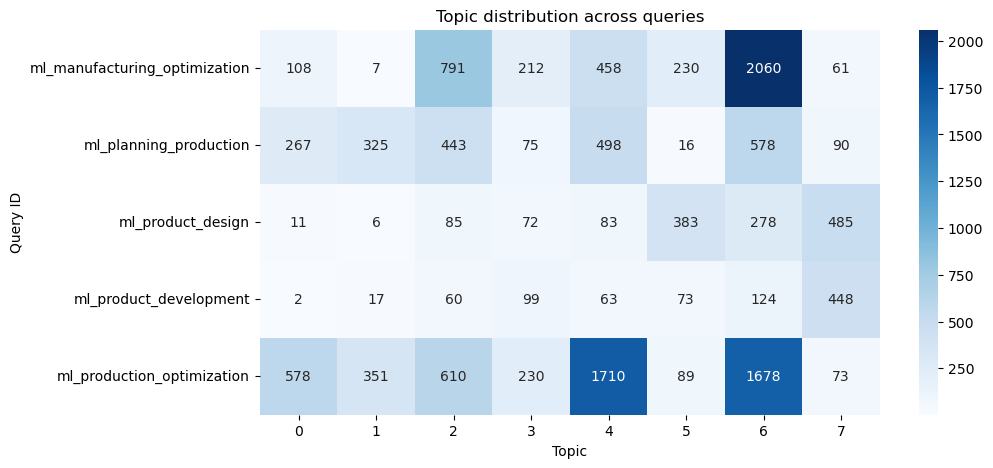

In [17]:
# Count how many abstracts per query belong to each topic
topic_dist = df.groupby(["query_id", "topic"]).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
sns.heatmap(topic_dist, cmap="Blues", annot=True, fmt="d")
plt.title("Topic distribution across queries")
plt.ylabel("Query ID")
plt.xlabel("Topic")
plt.show()


In [19]:
# Save results for later analysis
df.to_csv("../../reports/tables/abstract_topics.csv", index=False)
print("Saved topic assignments to ../reports/tables/abstract_topics.csv")


Saved topic assignments to ../reports/tables/abstract_topics.csv
